In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-10-19 04:16:06.232837: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 04:16:06.236099: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 04:16:06.245241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 04:16:06.259743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 04:16:06.264316: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 04:16:06.276780: I tensorflow/core/platform/cpu_feature_gu

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dbpedia-classes/DBP_wiki_data.csv
/kaggle/input/dbpedia-classes/DBPEDIA_test.csv
/kaggle/input/dbpedia-classes/DBPEDIA_val.csv
/kaggle/input/dbpedia-classes/DBPEDIA_train.csv
/kaggle/input/vectors-glove-300d/other/default/1/glove.6B.300d.txt


In [7]:
df_train = pd.read_csv('/kaggle/input/dbpedia-classes/DBPEDIA_train.csv')
df_test = pd.read_csv('/kaggle/input/dbpedia-classes/DBPEDIA_test.csv')
df_val = pd.read_csv('/kaggle/input/dbpedia-classes/DBPEDIA_val.csv')

In [8]:
'''df_train=pd.read_csv('DBPEDIA_train.csv',encoding='utf-8-sig')
df_test=pd.read_csv('DBPEDIA_test.csv',encoding='utf-8-sig')
df_val=pd.read_csv('DBPEDIA_val.csv',encoding='utf-8-sig')'''

"df_train=pd.read_csv('DBPEDIA_train.csv',encoding='utf-8-sig')\ndf_test=pd.read_csv('DBPEDIA_test.csv',encoding='utf-8-sig')\ndf_val=pd.read_csv('DBPEDIA_val.csv',encoding='utf-8-sig')"

In [9]:
df_train.head()

,text,l1,l2,l3
0,"William Alexander Massey (October 7, 1856 – Ma...",Agent,Politician,Senator
1,Lions is the sixth studio album by American ro...,Work,MusicalWork,Album
2,"Pirqa (Aymara and Quechua for wall, hispaniciz...",Place,NaturalPlace,Mountain
3,Cancer Prevention Research is a biweekly peer-...,Work,PeriodicalLiterature,AcademicJournal
4,The Princeton University Chapel is located on ...,Place,Building,HistoricBuilding


In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
with open('/kaggle/working/stopwords.txt', 'w') as f:
    for word in stop_words:
        f.write(f"{word}\n")
with open('/kaggle/working/stopwords.txt', 'r') as f:
    stopwords = set(f.read().splitlines())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess_dataframe(df):
    df['Category'] = df['l1'] + '|' + df['l2'] + '|' + df['l3']
    def preprocess_text(text):
        text = str(text)
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        words = text.split()
        #st_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        #ords = [lemmatizer.lemmatize(word) for word in words]
        text = ' '.join(words)
        return text
    df['Text'] = df['text'].apply(preprocess_text)
    return df

In [12]:
df_train = preprocess_dataframe(df_train)
df_test = preprocess_dataframe(df_test)
df_val = preprocess_dataframe(df_val)

In [13]:
df_train = pd.concat([df_train, df_val], ignore_index=True)

In [14]:
df_train['Category'].nunique()

219

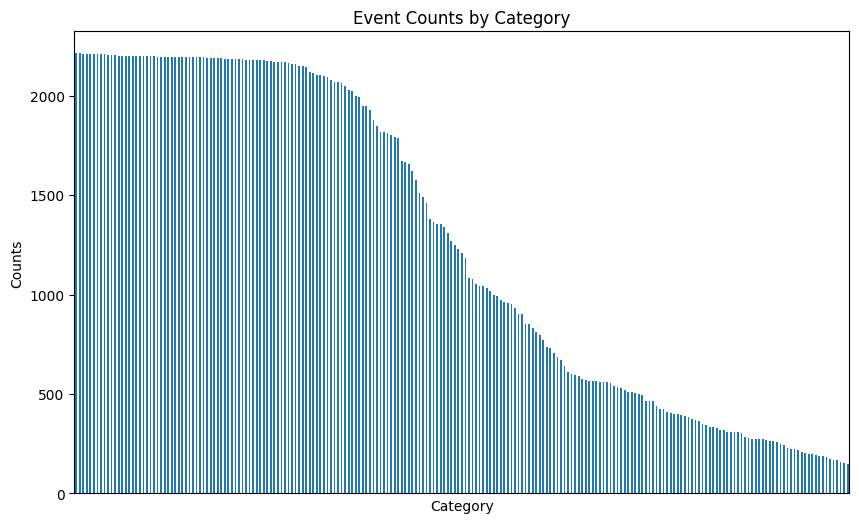

In [15]:
event_counts = df_train['Category'].value_counts()
test_counts =  df_test['Category'].value_counts()
plt.figure(figsize=(10, 6))
event_counts.plot(kind='bar')
plt.title('Event Counts by Category')
plt.ylabel('Counts')
plt.xticks([]) 
plt.show()

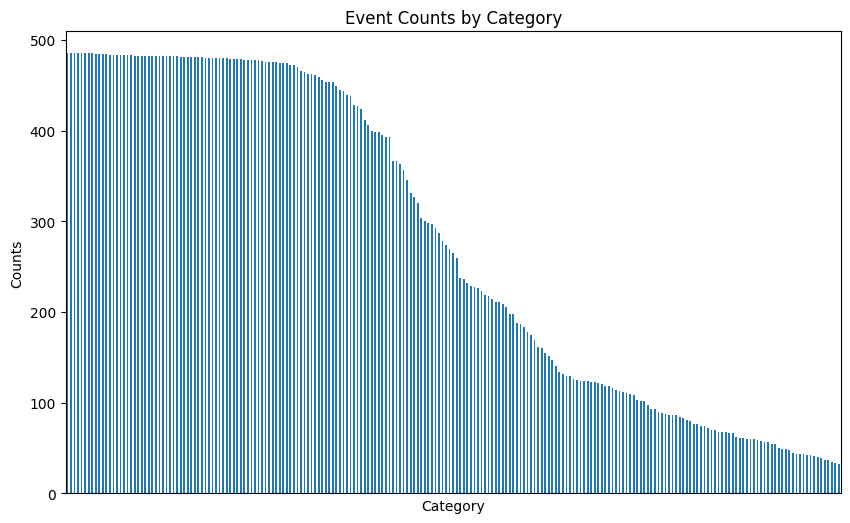

In [16]:
plt.figure(figsize=(10, 6))
test_counts.plot(kind='bar')
plt.title('Event Counts by Category')
plt.ylabel('Counts')
plt.xticks([]) 
plt.show()

In [17]:
def balancing(df,limitdf):
    counts = df['Category'].value_counts()
    df_balanced = pd.DataFrame()
    for category, count in counts.items():
        if count> limitdf:
            sampled = df[df['Category'] == category].sample(n=limitdf, random_state=42)
        else:
            sampled = df[df['Category'] == category]
        df_balanced = pd.concat([df_balanced, sampled])
    df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

In [18]:
df_train = balancing(df_train, 1000)
df_test = balancing(df_test, 200)

In [19]:
df_train['Text_lenght'] = df_train['Text'].str.len()
df_train['Text_lenght'].describe()

count    164861.000000
mean        427.401478
std         365.115856
min          27.000000
25%         169.000000
50%         307.000000
75%         565.000000
max        3076.000000
Name: Text_lenght, dtype: float64

In [20]:
df_test['Text_lenght'] = df_test['Text'].str.len()
df_test['Text_lenght'].describe()

count    33801.000000
mean       423.829236
std        363.866547
min         23.000000
25%        167.000000
50%        302.000000
75%        558.000000
max       3039.000000
Name: Text_lenght, dtype: float64

In [21]:
label_encoder = LabelEncoder()
df_train['Encoded_Category'] = label_encoder.fit_transform(df_train['Category'])

In [22]:
df_test['Encoded_Category'] = label_encoder.transform(df_test['Category'])

In [23]:
X_train, X_test, y_train, y_test = df_train['Text'], df_test['Text'], df_train['Encoded_Category'], df_test['Encoded_Category']

In [24]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

#pad the text
max_length = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [25]:
embeddings_index = {}
with open('/kaggle/input/vectors-glove-300d/other/default/1/glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 300
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Input

max_length = X_train_pad.shape[1]
embedding_dim = 300

model = Sequential()
model.add(Input(shape=(max_length,)))
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                   output_dim=embedding_dim,
                   weights=[embedding_matrix],
                   trainable=False))
model.add(Conv1D(64, kernel_size= 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(len(df_train['Category'].unique()), activation='softmax'))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 391, 300)       │   118,210,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 387, 64)        │        96,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 193, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 193, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 193, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 193, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 193, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 219)            │        28,251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,456,499 (451.88 MB)

 Trainable params: 246,235 (961.86 KB)

 Non-trainable params: 118,210,264 (450.94 MB)

In [27]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True,mode='max')
history = model.fit(X_train_pad, y_train, epochs=70, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/70
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 143s 65ms/step - accuracy: 0.1249 - loss: 4.0919 - val_accuracy: 0.5714 - val_loss: 1.6197
Epoch 2/70
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 134s 65ms/step - accuracy: 0.3423 - loss: 2.3645 - val_accuracy: 0.6623 - val_loss: 1.2340
Epoch 3/70
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 134s 65ms/step - accuracy: 0.4252 - loss: 2.0008 - val_accuracy: 0.7160 - val_loss: 1.0127
Epoch 4/70
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 133s 65ms/step - accuracy: 0.4560 - loss: 1.8957 - val_accuracy: 0.7450 - val_loss: 0.9527
Epoch 5/70
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 130s 63ms/step - accuracy: 0.4915 - loss: 1.7473 - val_accuracy: 0.7426 - val_loss: 0.9085
Epoch 6/70
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 132s 64ms/step - accuracy: 0.4993 - loss: 1.7167 - val_accuracy: 0.7583 - val_loss: 0.8753
Epoch 7/70
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 130s 63ms/step - accuracy: 0.5123 - loss: 1.6773 - val_accuracy: 0.7535 - val_loss: 0.8670
Epoch 8/70
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 129s 62ms/step - accuracy: 

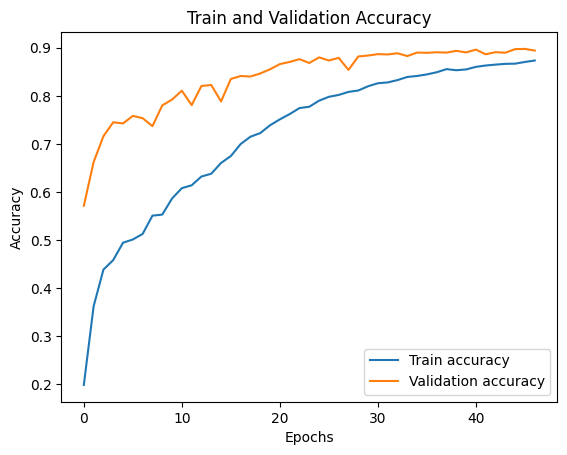

In [30]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='Train accuracy')   
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
train_loss, train_accuracy = model.evaluate(X_train_pad, y_train)
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)

5152/5152 ━━━━━━━━━━━━━━━━━━━━ 103s 20ms/step - accuracy: 0.9291 - loss: 0.2978
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8825 - loss: 0.5546


In [32]:
import os 
save_dir = 'model_components'
os.makedirs(save_dir, exist_ok=True)
import pickle
model.save(os.path.join(save_dir, 'best_model.keras'))
with open(os.path.join(save_dir, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)
with open(os.path.join(save_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)
with open(os.path.join(save_dir, 'max_length.pkl'), 'wb') as f:
    pickle.dump(max_length, f)
with open(os.path.join(save_dir, 'embedding_dim.pkl'), 'wb') as f:
    pickle.dump(embedding_dim, f)
with open(os.path.join(save_dir, 'embedding_matrix.pkl'), 'wb') as f:
    pickle.dump(embedding_matrix, f)

In [3]:
import os
import pickle
from keras.models import load_model

save_dir = 'model_components'

# Load the tokenizer
with open(os.path.join(save_dir, 'tokenizer.pkl'), 'rb') as f:
    tokenizer = pickle.load(f)

# Load the label encoder
with open(os.path.join(save_dir, 'label_encoder.pkl'), 'rb') as f:
    label_encoder = pickle.load(f)

# Load max_length
with open(os.path.join(save_dir, 'max_length.pkl'), 'rb') as f:
    max_length = pickle.load(f)

with open(os.path.join(save_dir, 'stop_words.pkl'), 'rb') as f:
    stop_words = pickle.load(f)

2024-10-19 04:27:49.862690: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 04:27:49.865984: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 04:27:49.873637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 04:27:49.888258: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 04:27:49.892362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 04:27:49.904273: I tensorflow/core/platform/cpu_feature_gu

In [4]:
from transformers import AutoModel, AutoTokenizer

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import huggingface_hub
print(huggingface_hub.__version__)

0.26.0


In [10]:
import os
import keras
import huggingface_hub
os.environ["KERAS_BACKEND"] = "tensorflow"
model = keras.saving.load_model("hf://bainskarman/WikiClassification")

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 94.63it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/codespace/.cache/huggingface/hub/models--bainskarman--WikiClassification/snapshots/47916e307819a0e9ef5b7948b3e34c50d4b4844b/config.json'

In [2]:
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    st_words = stop_words
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    return text
def classify_text(text):
    text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = np.pad(seq, ((0, 0), (0, max_length - len(seq[0]))), mode='constant')

    prediction = model.predict(padded_seq)
    predicted_label_index = np.argmax(prediction, axis=1)[0]
    predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]
    categories = predicted_label.split('|')
    
    if len(categories) == 3:
        main_category = categories[0]
        sub_category = categories[1]
        lowest_category = categories[2]
    else:
        main_category = "Unknown"
        sub_category = "Unknown"
        lowest_category = "Unknown"
    print(f"Main Category: {main_category}, Sub Category: {sub_category}, Lowest Category: {lowest_category}")

In [13]:
import streamlit as st
import pickle
import numpy as np
import os
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

save_dir = 'model_components'

# Load the tokenizer
with open(os.path.join(save_dir, 'tokenizer.pkl'), 'rb') as f:
    tokenizer = pickle.load(f)

# Load the label encoder
with open(os.path.join(save_dir, 'label_encoder.pkl'), 'rb') as f:
    label_encoder = pickle.load(f)

# Load max_length
with open(os.path.join(save_dir, 'max_length.pkl'), 'rb') as f:
    max_length = pickle.load(f)

with open(os.path.join(save_dir, 'stop_words.pkl'), 'rb') as f:
    stop_words = pickle.load(f)
lemmatizer = WordNetLemmatizer()

/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
